In [1]:
import torch
import pandas as pd
import numpy as np


In [2]:
data = torch.load('preprocessed_data.pt')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
sample_weights = data['sample_weights']


In [3]:
import torch.nn as nn

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # regression output

    def forward(self, x):
        # LSTM returns output for all time steps and (hidden, cell)
        out, _ = self.lstm(x)
        # Use output from last time step
        last_time_step_out = out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out.squeeze()  # remove singleton dimension for regression


In [ ]:

def weighted_mse_loss(predictions, targets, weights):
    return torch.mean(weights * (predictions - targets) ** 2)

In [32]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Datasets
train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train.shape[2]  # number of SHARP features
model = LSTMModel(input_size=input_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [34]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/10 - Train Loss: 5.6299 - Val Loss: 2.9366
Epoch 2/10 - Train Loss: 2.8653 - Val Loss: 2.6972
Epoch 3/10 - Train Loss: 2.5525 - Val Loss: 2.4137
Epoch 4/10 - Train Loss: 2.4592 - Val Loss: 2.3761
Epoch 5/10 - Train Loss: 2.4329 - Val Loss: 2.3256
Epoch 6/10 - Train Loss: 2.4061 - Val Loss: 2.3151
Epoch 7/10 - Train Loss: 2.3792 - Val Loss: 2.3477
Epoch 8/10 - Train Loss: 2.3624 - Val Loss: 2.2947
Epoch 9/10 - Train Loss: 2.3489 - Val Loss: 2.2775
Epoch 10/10 - Train Loss: 2.3314 - Val Loss: 2.2578


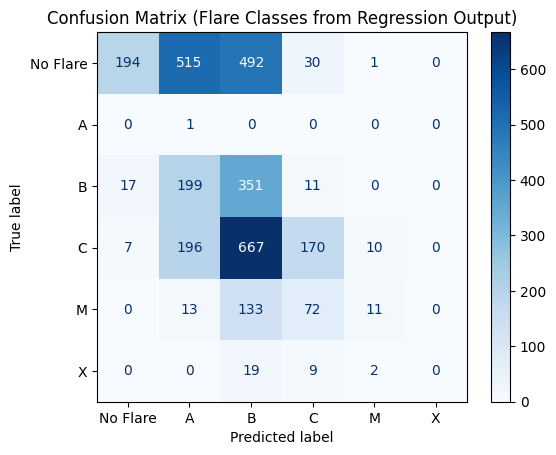

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate model on validation set
model.eval()
all_preds = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_preds.extend(outputs.cpu().numpy())

y_pred = np.array(all_preds)
y_true = y_val.cpu().numpy()  # regression ground truth

# Convert predictions and targets from log-scale to linear scale
y_pred_linear = 10 ** y_pred
y_true_linear = 10 ** y_true

# Define intensity bins for flare classes
bins = [0.0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, np.inf]
labels = ['No Flare', 'A', 'B', 'C', 'M', 'X']
class_indices = list(range(len(labels)))  # [0, 1, 2, 3, 4]

# Bin true and predicted values into classes
y_true_class = np.digitize(y_true_linear, bins) - 1
y_pred_class = np.digitize(y_pred_linear, bins) - 1

# Compute and plot confusion matrix
unique_labels = sorted(np.unique(np.concatenate([y_true_class, y_pred_class])))
cm = confusion_matrix(y_true_class, y_pred_class, labels=unique_labels)

# Use corresponding display labels (e.g., ['A', 'B', 'C', 'M', 'X'])
display_labels = [labels[i] for i in unique_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)9
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Flare Classes from Regression Output)")
plt.show()



In [ ]:
# Show prediction range
print("Prediction min:", y_pred.min())
print("Prediction max:", y_pred.max())

# Show a few prediction samples
print("Sample predictions:", y_pred[:10])


Prediction min: -8.903355
Prediction max: -4.2955685
Sample predictions: [-7.015794  -7.8043942 -8.036554  -6.9841094 -6.71221   -7.9131765
 -6.3900294 -6.401261  -6.4103026 -6.8125267]


: 